In [ ]:
import os
import numpy as np
from tqdm import tqdm
from trunk_sim.data import TrunkData
from trunk_sim.policy import HarmonicPolicy, RandomWalkPolicy, steady_state_input
from trunk_sim.rollout import rollout
from utils.plotting import plot_trajectories, plot_trunk_results
from utils.ssm import DelaySSM, OptSSM
from utils.systems import Trunk
from utils.models import SSMR, get_residual_labels
from utils.residual import ResidualBr, PolyBr
from utils.mpc import generate_ref_trajectory, run_mpc
from utils.misc import HyperRectangle
from utils.gusto import GuSTOConfig
import jax
import jax.numpy as jnp

INFO   2025-04-10 12:20:11 xla_bridge Unable to initialize backend 'cuda': 
INFO   2025-04-10 12:20:11 xla_bridge Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO   2025-04-10 12:20:11 xla_bridge Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [2]:
# Instantiate Trunk simulator
trunk = Trunk()

Number of autonomous data points:  20000


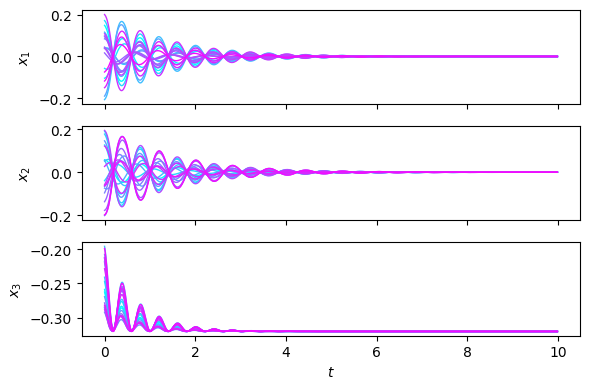

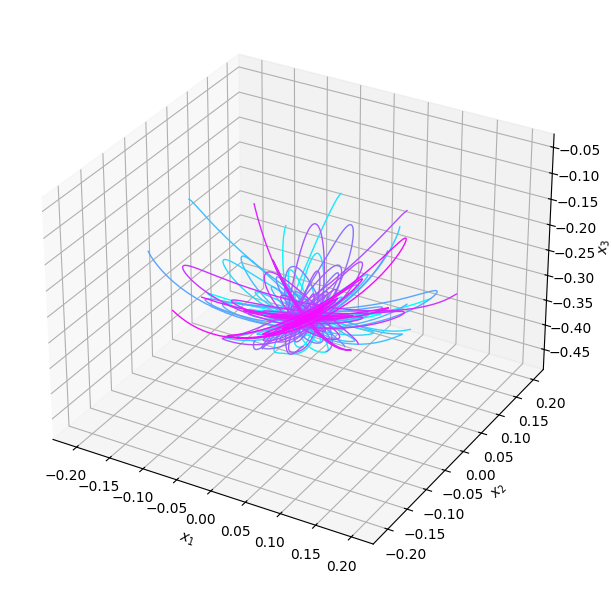

In [3]:
# Instantiate Trunk Data class
trunk_aut_data = TrunkData(
    trunk.num_links_per_segment,
    trunk.num_segments,
    states="pos_vel",
    segments="all",
)

# Collect autonomous Trunk data
def collect_data(system: Trunk,
                 data: TrunkData,
                 num_rollouts: int = 20,
                 policy: str = "none",
                 name: str = "autonomous_data"
                 ):
    if not os.path.exists(system.data_folder):
        os.makedirs(system.data_folder)

    if system.render_video and not os.path.exists(
        os.path.join(system.data_folder, "videos")
    ):
        os.makedirs(os.path.join(system.data_folder, "videos"))

    if policy == "harmonic":
        policy = HarmonicPolicy(
            frequency_range=[0.5, 5],
            amplitude_range=[0.5, 2.5],
            phase_range=[0, 2 * np.pi],
            num_segments=trunk.num_segments
        )
    elif policy == "random_walk":
        policy = RandomWalkPolicy()
    elif policy == "none":
        policy = None
    else:
        raise ValueError(f"Invalid policy: {policy}")
    
    for rollout_idx in tqdm(range(num_rollouts)):

        if system.init_steady_state:
            angle = np.random.uniform(0,2*np.pi)
            sign = np.random.choice([-1,1])
            system.simulator.set_initial_steady_state(
                steady_state_input(system.simulator.num_segments, amplitude=np.random.uniform(0.0, 15.0), angle=angle),
                kick=steady_state_input(system.simulator.num_segments, amplitude=np.random.uniform(5.0, 12.5), angle=angle + np.pi/2 * sign),
                kick_duration=0.5,
            )

        rollout(
            simulator=system.simulator,
            policy=policy,
            data=data,
            duration=system.duration,
            render_video=system.render_video,
            video_filename=os.path.join(
                system.data_folder, "videos", f"rollout_{rollout_idx}.mp4"
            ),
            stop_at_convergence=system.stop_at_convergence,
            traj_ID = rollout_idx
        )

    data.save_to_csv(os.path.join(system.data_folder, name + ".csv"))

COLLECT = False
if COLLECT:
    collect_data(trunk, trunk_aut_data)
else:
    trunk_aut_data.load_from_csv(os.path.join(trunk.data_folder, "autonomous_data.csv"))
print("Number of autonomous data points: ", len(trunk_aut_data))

# Extract arrays
tss, aut_trajs, _, _ = trunk_aut_data.convert_to_arrays()

# Visualize tip trajectories
plot_trajectories(aut_trajs[:, 12:15], tss[0])

# Find optimal (oblique) linear projection and compare with orthogonal projection

In [4]:
N_aut_train = 10
tip_positions = jnp.array(aut_trajs[:N_aut_train, 12:15])
tip_velocities = jnp.array(aut_trajs[:N_aut_train, 15:18])
aut_trajs_obs = tip_positions
ts = tss[0]

# Center the Z coordinate
aut_trajs_obs = aut_trajs_obs.at[:, 2].set(aut_trajs_obs[:, 2] - jnp.mean(aut_trajs_obs[:, 2, -1]))

ssm_opt = OptSSM(aut_trajs_obs=aut_trajs_obs,
                 t_split=3.5,
                 SSMDim=5,
                 SSMOrder=2,
                 ROMOrder=2,
                 N_delay=3,
                 ts=ts,
                 verbose=True)

ssm_orth = DelaySSM(aut_trajs_obs=aut_trajs_obs,
                     SSMDim=5,
                     SSMOrder=2,
                     ROMOrder=2,
                     N_delay=3,
                     N_obs_delay=3,
                     orthogonalize=True,
                     ts=ts)

Ipopt 3.14.16: max_iter=500
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:   628950
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:  8506050

Total number of variables............................:   105160
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................

INFO   2025-04-10 12:22:53 ridge Transforming data
INFO   2025-04-10 12:22:53 ridge Skipping CV on ridge regression
INFO   2025-04-10 12:22:53 ridge Fitting regression model
INFO   2025-04-10 12:22:53 ridge Transforming data
INFO   2025-04-10 12:22:53 ridge Skipping CV on ridge regression
INFO   2025-04-10 12:22:53 ridge Fitting regression model
INFO   2025-04-10 12:22:53 ridge Transforming data
INFO   2025-04-10 12:22:53 ridge Skipping CV on ridge regression
INFO   2025-04-10 12:22:53 ridge Fitting regression model
INFO   2025-04-10 12:22:53 ridge Transforming data
INFO   2025-04-10 12:22:53 ridge Skipping CV on ridge regression
INFO   2025-04-10 12:22:53 ridge Fitting regression model


# Simulate controlled system
Two control inputs per joint that decompose into torque and force along the pendulum.

Number of controlled data points:  30000


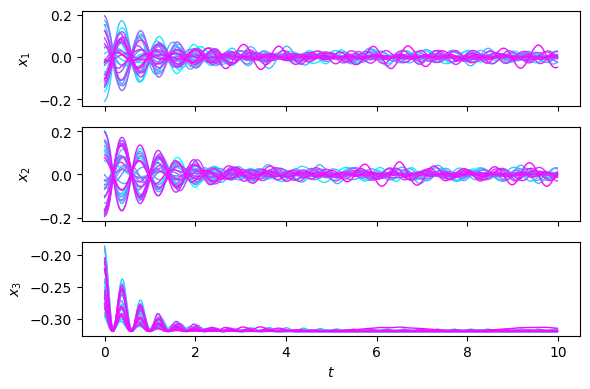

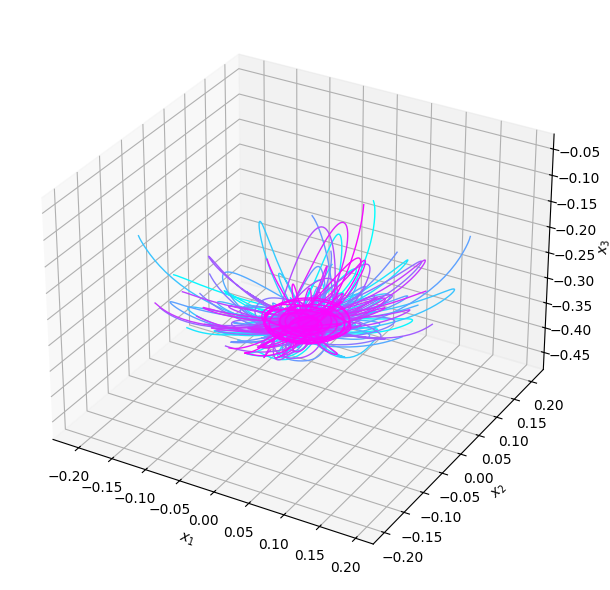

In [5]:
# Instantiate Trunk Data class
trunk_ctrl_data = TrunkData(
    trunk.num_links_per_segment,
    trunk.num_segments,
    states="pos_vel",
    segments="all",
)

COLLECT = False
if COLLECT:
    collect_data(trunk, trunk_ctrl_data, num_rollouts=30, policy="harmonic", name="controlled_data")
else:
    trunk_ctrl_data.load_from_csv(os.path.join(trunk.data_folder, "controlled_data.csv"))
print("Number of controlled data points: ", len(trunk_ctrl_data))

# Extract arrays
tss, ctrl_trajs, control_inputs, _ = trunk_ctrl_data.convert_to_arrays()

# Visualize tip trajectories
plot_trajectories(ctrl_trajs[:, 12:15], tss[0])

In [6]:
N_ctrl_train = 20
ctrl_tip_positions = jnp.array(ctrl_trajs[:N_ctrl_train, 12:15])
ctrl_tip_velocities = jnp.array(ctrl_trajs[:N_ctrl_train, 15:18])
ctrl_trajs_obs = ctrl_tip_positions
us = control_inputs[:N_ctrl_train]
ts = tss[0]

# Center the Z coordinate
ctrl_trajs_obs = ctrl_trajs_obs.at[:, 2].set(ctrl_trajs_obs[:, 2] - jnp.mean(ctrl_trajs_obs[:, 2, -1]))

# Fit B_r for both models

In [7]:
# Obtain labels used to fit B_r
xs_flat, us_flat, delta_x_dots_flat = get_residual_labels(ssm_orth, ctrl_trajs_obs, ts, us=us)

# Fit the residual model
poly_B_r = PolyBr(5, 6, 0, 0.0)
poly_B_r.fit(xs_flat, us_flat, delta_x_dots_flat)
residual_B_r = ResidualBr(poly_B_r)
obs_perf_matrix = jnp.zeros((3, (ssm_orth.N_obs_delay + 1) * 3))
obs_perf_matrix = obs_perf_matrix.at[:, 0:3].set(jnp.eye(3))
ssmr_orth = SSMR(ssm_orth, residual_B_r, obs_perf_matrix)

# Likewise for the optimal projection model
xs_flat, us_flat, delta_x_dots_flat = get_residual_labels(ssm_opt, ctrl_trajs_obs, ts, us=us)
poly_B_r = PolyBr(5, 6, 0, 0.0)
poly_B_r.fit(xs_flat, us_flat, delta_x_dots_flat)
residual_B_r = ResidualBr(poly_B_r)
ssmr_opt = SSMR(ssm_opt, residual_B_r, obs_perf_matrix)

# Run MPC

In [30]:
# Generate reference trajectory
dt = 0.01
T_f = 2.5
t_mpc = jnp.arange(0, T_f+dt, dt)
traj_type = 'figure_eight'
if traj_type == 'figure_eight':
    z_ref = generate_ref_trajectory(t_mpc, type=traj_type, T=T_f, A=0.125, dim=3)
elif traj_type == 'circle':
    z_ref = generate_ref_trajectory(t_mpc, type=traj_type, T=T_f, A=0.2, dim=2)

In [49]:
# Set MPC parameters
u_scale = 0.1
ρ, dρ = 1e-7, 1e-3
R = ρ * u_scale**2 * jnp.eye(ssmr_orth.n_u)
R_du = dρ * u_scale**2 * jnp.eye(ssmr_orth.n_u)
Q = jnp.eye(ssmr_orth.n_z)
Q = Q.at[2, 2].set(0.0)
gusto_config_orth = GuSTOConfig(
    Qz=Q,
    Qzf=Q,
    R=R,
    R_du=R_du,
    x_char=jnp.ones(ssmr_orth.n_x),
    f_char=jnp.ones(ssmr_orth.n_x),
    N=8,
    dt=dt
)
gusto_config_opt = GuSTOConfig(
    Qz=Q,
    Qzf=5*Q if traj_type == 'figure_eight' else Q,
    R=10*R,
    R_du=R_du,
    x_char=jnp.ones(ssmr_opt.n_x),
    f_char=jnp.ones(ssmr_opt.n_x),
    N=8,
    dt=dt
)

In [50]:
# Solve MPC problem
U = HyperRectangle([20.0] * 6, [-20.0] * 6)  # set bounds on control inputs if desired (not tight here)
x_mpc_orth, z_mpc_orth, u_mpc_orth, z_true_orth = run_mpc(
    trunk,
    ssmr_orth,
    gusto_config_orth,
    z_ref,
    U=U,
    dU=None,
    N_exec=2)
x_mpc_opt, z_mpc_opt, u_mpc_opt, z_true_opt = run_mpc(
    trunk,
    ssmr_opt,
    gusto_config_opt,
    z_ref,
    U=U,
    dU=None,
    N_exec=2)

First solve may take a while due to factorization and caching.
Solved in 1 iterations/14.747 seconds, with 0.001 s from LOCP solve


  0%|          | 0/242 [00:00<?, ?it/s]

Solved in 2 iterations/0.063 seconds, with 0.005 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.011 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.011 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.011 seconds, with 0.001 s from LOCP s

  0%|          | 0/242 [00:00<?, ?it/s]

Solved in 1 iterations/0.012 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.008 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.011 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.008 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.008 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.008 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.008 seconds, with 0.001 s from LOCP s

In [51]:
# Compute integrated squared error
def compute_ise(i_start, i_end, z_ref, z_true, dim=2):
    if dim == 2:
        return jnp.sum((jnp.linalg.norm(z_true[i_start:i_end, :2] - z_ref[i_start:i_end, :2], axis=1)) ** 2 * dt)
    elif dim == 3:
        return jnp.sum((jnp.linalg.norm(z_true[i_start:i_end, :3] - z_ref[i_start:i_end, :3], axis=1)) ** 2 * dt)

if traj_type == 'circle':
    i_start = 15
elif traj_type == 'figure_eight':
    i_start = 0

ise_orth = compute_ise(i_start, -gusto_config_orth.N, z_ref, z_true_orth)
ise_opt = compute_ise(i_start, -gusto_config_opt.N, z_ref, z_true_opt)
print("ISE (orthogonal):", ise_orth*10**4, "cm^2")
print("ISE (oblique):", ise_opt*10**4, "cm^2")

ISE (orthogonal): 0.99141705 cm^2
ISE (oblique): 0.5542147 cm^2


In [64]:
from importlib import reload
import utils.plotting
reload(utils.plotting)
from utils.plotting import plot_trunk_results

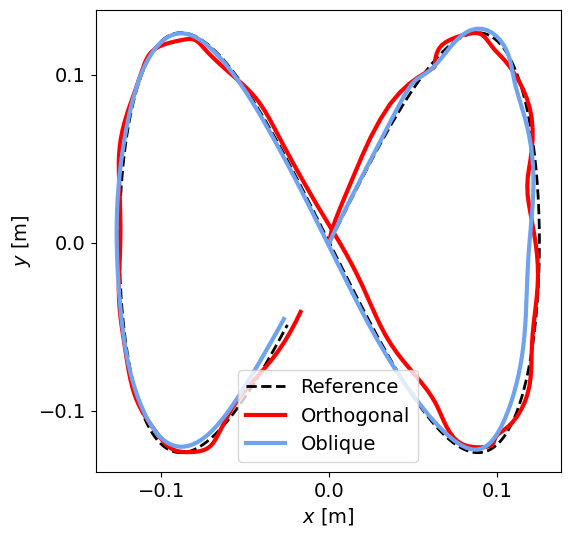

In [65]:
# Plot the results
plot_trunk_results(z_ref, z_true_orth, z_true_opt, gusto_config_opt.N)